### Адаптивный фильтр Калмана
Реализация алгоритма адаптивной фильтрации на основе алгоритма Калмана.

In [1]:
import numpy as np
import scipy as sp
from scipy.io import wavfile
import matplotlib.pyplot as plt
import IPython.display as ipd

In [2]:
# Magic numbers
SOUND_SPEED = 343   # скорость звука, м/с
SAMPLERATE = 44100  # частота дискретизации, Гц
MICRO_DISTANCE = 10 # расстояние между микрофонами, см
DEBUG = 0           # включение отладочной информации, 0 - выкл
DUMMY = 0           # включить простое вычитание шума и создание аудиофайла, 0 - выкл

### Определение функций

In [3]:
def info(obj):
    """Function for displaying debugging information about object.

    Accepts an array or number as input. Prints the data type,
    shape and element.
    """
    print("\nDebug info:")
    print(f"type        = {type(obj)}")
    print(f"shape       = {obj.shape}")
    if len(obj) > 1:
        print(f"type obj[0] = {type(obj[0])}")
        print(f"obj[0]      = {obj[0]}")
    else:
        print(obj)
    print()
    
def get_raw_data(filename):
    """Gets data from .wav file.

    Takes a filename (string) as input.

    Returns the sample rate and an array of single
    channel samples in float64 format.

    Call example:
    sample_rate, sample = wavfile.read("Demobilizaciya.wav")
    sample_rate - sample rate value for Demobilizaciya.wav.
    sample      - Demobilizaciya.wav signal samples in
                  numpy.ndarray.float64 format.
    """
    sample_rate, sample = wavfile.read(filename)
    sample = sample.astype("float64")
    right_ch = sample[:,1]
    return sample_rate, right_ch

def write_wav(filename, sample_rate, sample):
    """Write data to .wav file.

    The input accepts the file name (string), sampling
    rate and signal samples.

    On output creates a .wav file with the given name.
    """
    sample = sample.astype("int16")
    wavfile.write(filename, sample_rate, sample)

def plot_spectrum(s, sample_rate, ax):
    """Creates a figure with the spectrum of the signal.

    Takes signal (s), sample rate (sample_rate) and
    axis (ax) as input.

    Returns a figure with the spectrum of the signal.

    Usage example:
    fig, ax = plt.subplots(1,2)
    plot_spectrum(signal_1, sample_rate_1, ax[0])
    plot_spectrum(signal_2, sample_rate_2, ax[1])
    # plots the signal spectrum
    """
    f = np.fft.rfftfreq(len(s), d=1./sample_rate)
    fig=ax.plot(f, np.abs(np.fft.rfft(s)/len(s)))
    return fig

### Получение исходных данных

In [4]:
# источник шума из микрофона 2
sample_rate_2, microphone_2 = get_raw_data("white_noize.wav")
print(f"sample_rate_2 = {sample_rate_2}")
if DEBUG: info(microphone_2)

# речь без шума
sample_rate_1, microphone_1 = get_raw_data("voice_original.wav")
print(f"sample_rate_1 = {sample_rate_1}")
if DEBUG: info(microphone_1)

sample_rate_2 = 44100
sample_rate_1 = 44100


In [5]:
ipd.Audio("voice_original.wav")

In [6]:
# масштабируем амплитуды сигналов от -1 до 1
max_mic_1 = np.max(microphone_1)        # максимальная амплитуда речевого сигнала
microphone_1 = microphone_1 / max_mic_1
microphone_2 = microphone_2 / max_mic_1 # амплитуда шума относительно амплитуды речи сохраняется

# бэкап оригинального звука для сравнения
microphone_1_bu = microphone_1

In [7]:
delay_sec = MICRO_DISTANCE * 10**-2 / SOUND_SPEED   # задержка в секундах
delay_samples = round(delay_sec * SAMPLERATE)       # задержка в сэмплах

if DEBUG: print(f"delay_sec: {delay_sec} sec")
print(f"Задержка между микрофонами = {delay_samples} samples")

Задержка между микрофонами = 13 samples


Передаточная функция фильтра:
$$H(z)=\frac{b_0+b_1\cdot z^{-1}+...+b_n\cdot z^{-n}}{a_0+a_1\cdot z^{-1}+...+a_m\cdot z^{-m}}$$
Передаточная функция задержки:
$$H(w)=z^{-delay}$$
Передаточная функция фильтра не должна изменять амплитуду и не должна вносить обратные связи, поэтому знаменатель должен быть равен 1, а знаменатель равен $b_{delay}=1$

In [8]:
# коэффициенты фильтра
b_coef = np.zeros((delay_samples - 1,), dtype=np.int16)
b_coef = np.append(b_coef, [1])
a_coef = [1]

# применяем передаточную функцию к источнику шума
microphone_2_delay = sp.signal.lfilter(b_coef, a_coef, microphone_2)

# добавляем источник задержанного шума к речевому сигналу
microphone_1 = microphone_2_delay + microphone_1

# воспроизвести звук с microphone_1
if DEBUG:
    debug_sound = np.array(microphone_1*max_mic_1, dtype=np.int16) # Масштабируем и приводим к типу int16
    write_wav("voice_and_noize.wav", sample_rate_1, debug_sound)

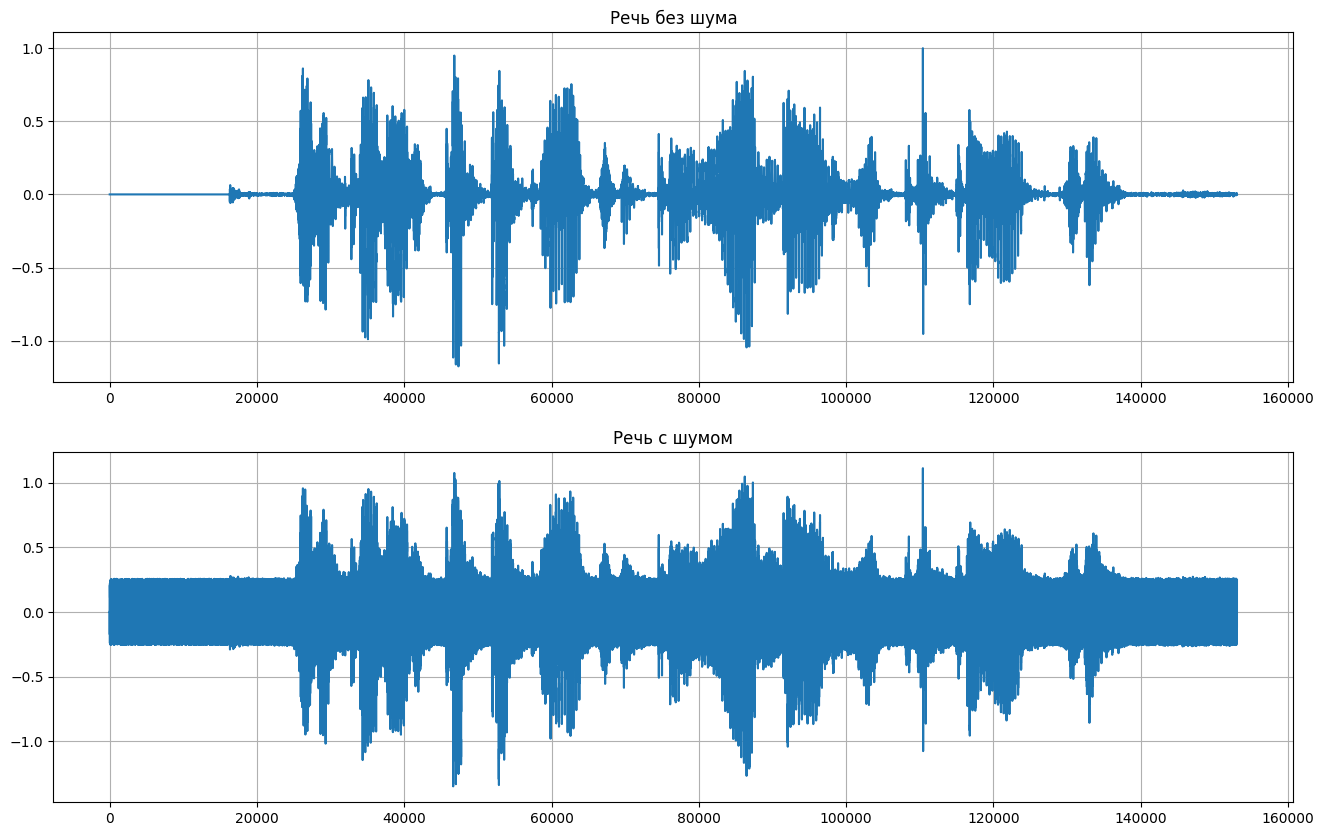

In [9]:
# Визуализация сигналов во временной области
fig, ax = plt.subplots(2, 1, figsize=(16, 10))
for i in ax:
    i.grid(True)
ax[0].plot(microphone_1_bu)
ax[0].set_title('Речь без шума')
ax[1].plot(microphone_1)
ax[1].set_title('Речь с шумом')
plt.show()

Text(0.5, 1.0, 'Спектр сигнала с микрофона 1')

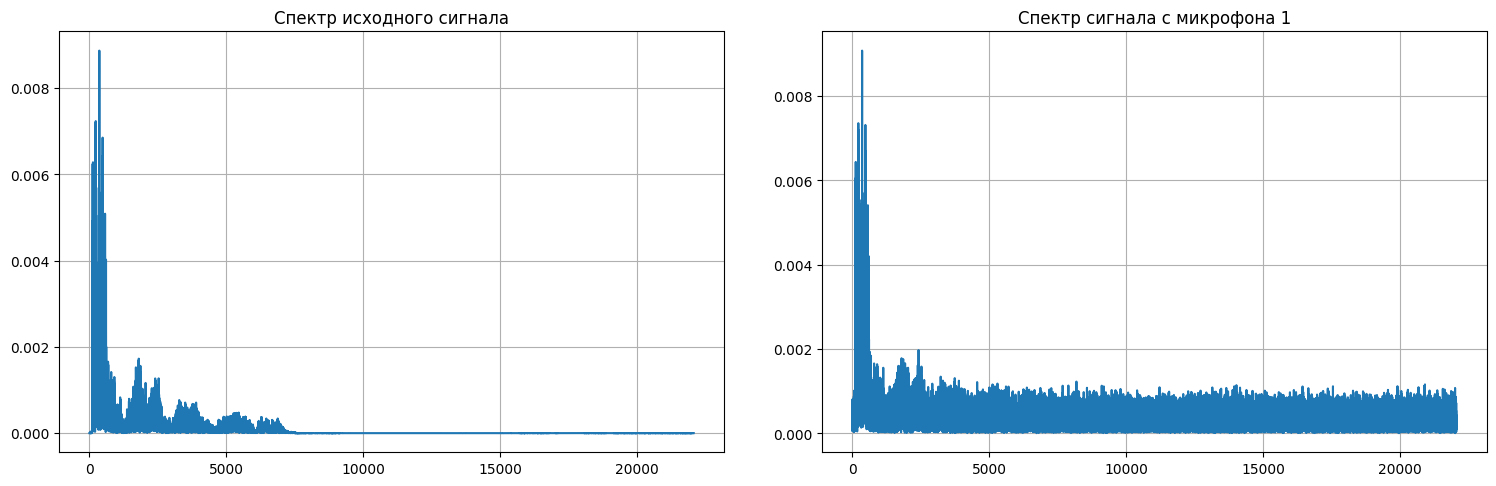

In [10]:
# Спектр сигналов
fig,ax=plt.subplots(1,2)
fig.set_figwidth(15)
fig.tight_layout(w_pad=4)
plot_spectrum(microphone_1_bu, sample_rate_1, ax[0])
plot_spectrum(microphone_1, sample_rate_1, ax[1])
for i in ax:
    i.grid(True)
ax[0].set_title('Спектр исходного сигнала')
ax[1].set_title('Спектр сигнала с микрофона 1')

In [11]:
# вычитание microphone_2 напрямую из microphone_1
# не приводит к желаемому результату
# DUMMY = 1
if DUMMY:
    debug_sound = microphone_1 - microphone_2
    debug_sound = np.array(debug_sound*max_mic_1, dtype=np.int16) # Масштабируем и приводим к типу int16
    write_wav("just_subtraction.wav", sample_rate_1, debug_sound)

### Фильтрация сигнала

Для фильтрации зашумленного сигнала использовался алгоритм Калмана.

HELP: http://pzs.dstu.dp.ua/DataMining/kalman/bibl/06.pdf

Выходной сигнал фильтра Калмана имеет вид:
$$ y(k) = u^T(k) \cdot w(k-1) $$
где $u(k)$ - вектор содержимого линии задержки фильтра (microphone_2)

Ошибка фильтрации (используется в качестве конечного сигнала):
$$ e(k) = d(k) - y(k) $$
где $d(k)$ - образцовый сигнал (microphone_1)

Расчет калмановского коэффициента усиления:
$$ K(k) = \frac{P(k-1) \cdot u(k)}{u^T(k) \cdot P(k-1) \cdot u(k) + Q_M} $$
где $Q_M$ - средний квадрат сигнала ошибки, $ (0.001...0.01)\sigma^2_d $

Обновление оценки коэффициентов фильтра:
$$ w(k) = w(k-1) + K(k) \cdot e(k) $$

Обновление оценки корреляционной матрицы ошибок оценивания:
$$ P(k) = P(k-1) - K(k) \cdot u^T \cdot P(k-1) + Q_p $$
где $Q_p$ - корреляционная матрица шума процесса (равна 0)

In [12]:
#sigma = np.std(microphone_1)
#sigma_2 = np.var(microphone_1)

FO  = 32                                        # порядок фильтра
N   = len(microphone_1)                         # число наблюдений
w   = np.zeros(FO)                              # массив коэффициентов фильтра
u   = np.concatenate((w, [0], microphone_2))    # входные данные + начальные значения в линии задержки фильтра
d   = np.concatenate(([0], microphone_1))       # ожидаемый результат + начальное значение
e   = 0                                         # сигнал ошибки (используется в качестве выхода фильтра)
y   = 0                                         # выходной сигнал фильтра
P = 1                                           # оценка корреляционной матрицы ошибок
Q_M = 0.001                                     # средний квадрат сигнала ошибки
Q_P = 0                                         # корреляционная матрица шума процесса
out = np.zeros(N)                               # выходные значения системы

for k in range(0, N):
    u_k = u[k+FO:k:-1]
    y = w.dot(u_k)
    e = d[k] - y
    K = (P * u_k) / (np.dot(u_k, u_k) * P + Q_M)
    P = P - K * u_k * P + Q_P
    w = w + K * e
    out[k] = e

### Визуализация результатов работы алгоритма

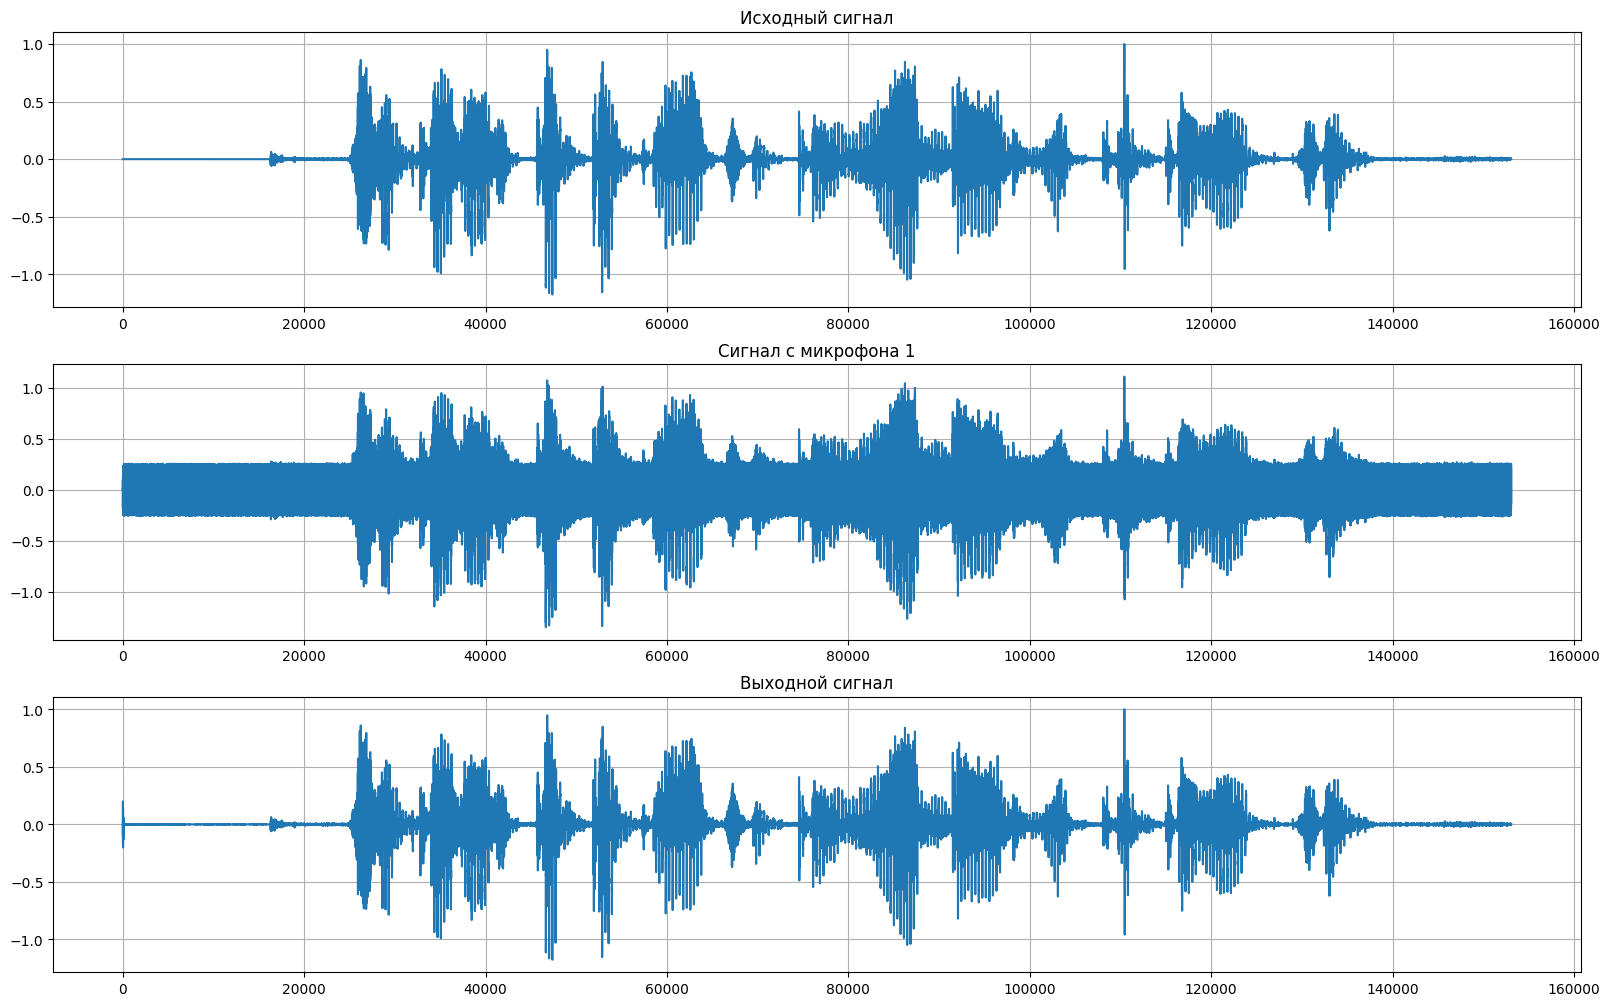

In [13]:
# Визуализация сигналов во временной области
fig, ax = plt.subplots(3, 1, figsize=(16, 10))
for i in ax:
    i.grid(True)
fig. tight_layout (h_pad=2)
ax[0].plot(microphone_1_bu)
ax[0].set_title("Исходный сигнал")
ax[1].plot(microphone_1)
ax[1].set_title("Сигнал с микрофона 1")
ax[2].plot(out)
ax[2].set_title("Выходной сигнал")
plt.show()

Text(0.5, 1.0, 'Спектр сигнала на выходе')

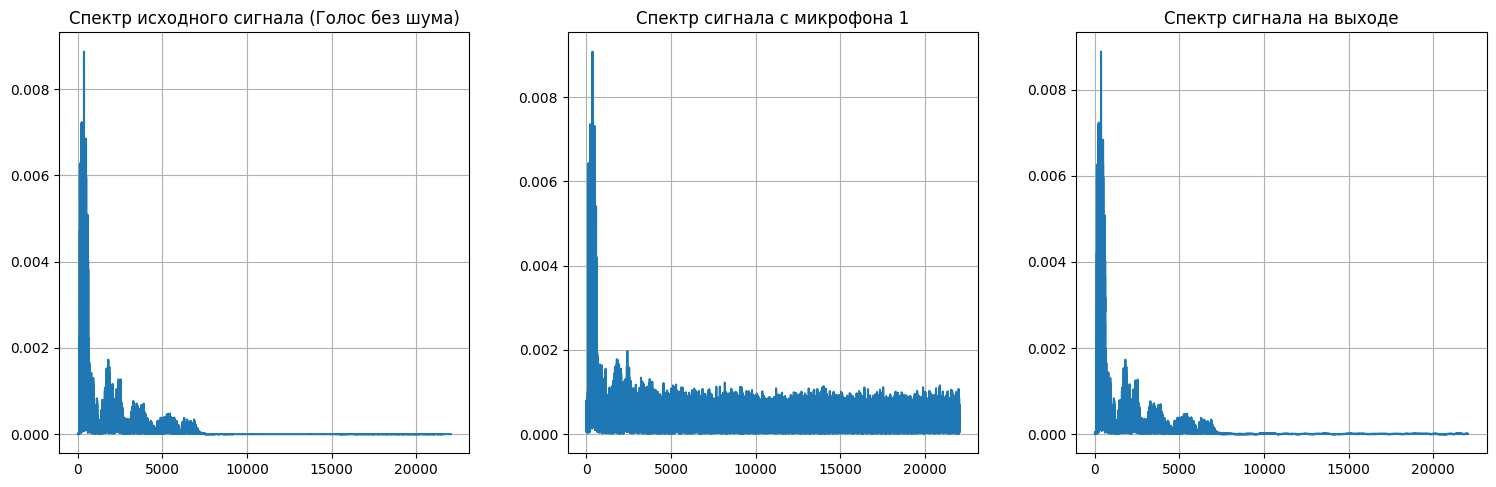

In [14]:
# Спектр сигналов
fig,ax=plt.subplots(1,3)
fig.set_figwidth(15)
fig.tight_layout(w_pad=4)
for i in ax:
    i.grid(True)
plot_spectrum(microphone_1_bu, sample_rate_1, ax[0])
plot_spectrum(microphone_1, sample_rate_1, ax[1])
plot_spectrum(out, sample_rate_1, ax[2])
ax[0].set_title('Спектр исходного сигнала (Голос без шума)')
ax[1].set_title('Спектр сигнала с микрофона 1')
ax[2].set_title('Спектр сигнала на выходе')

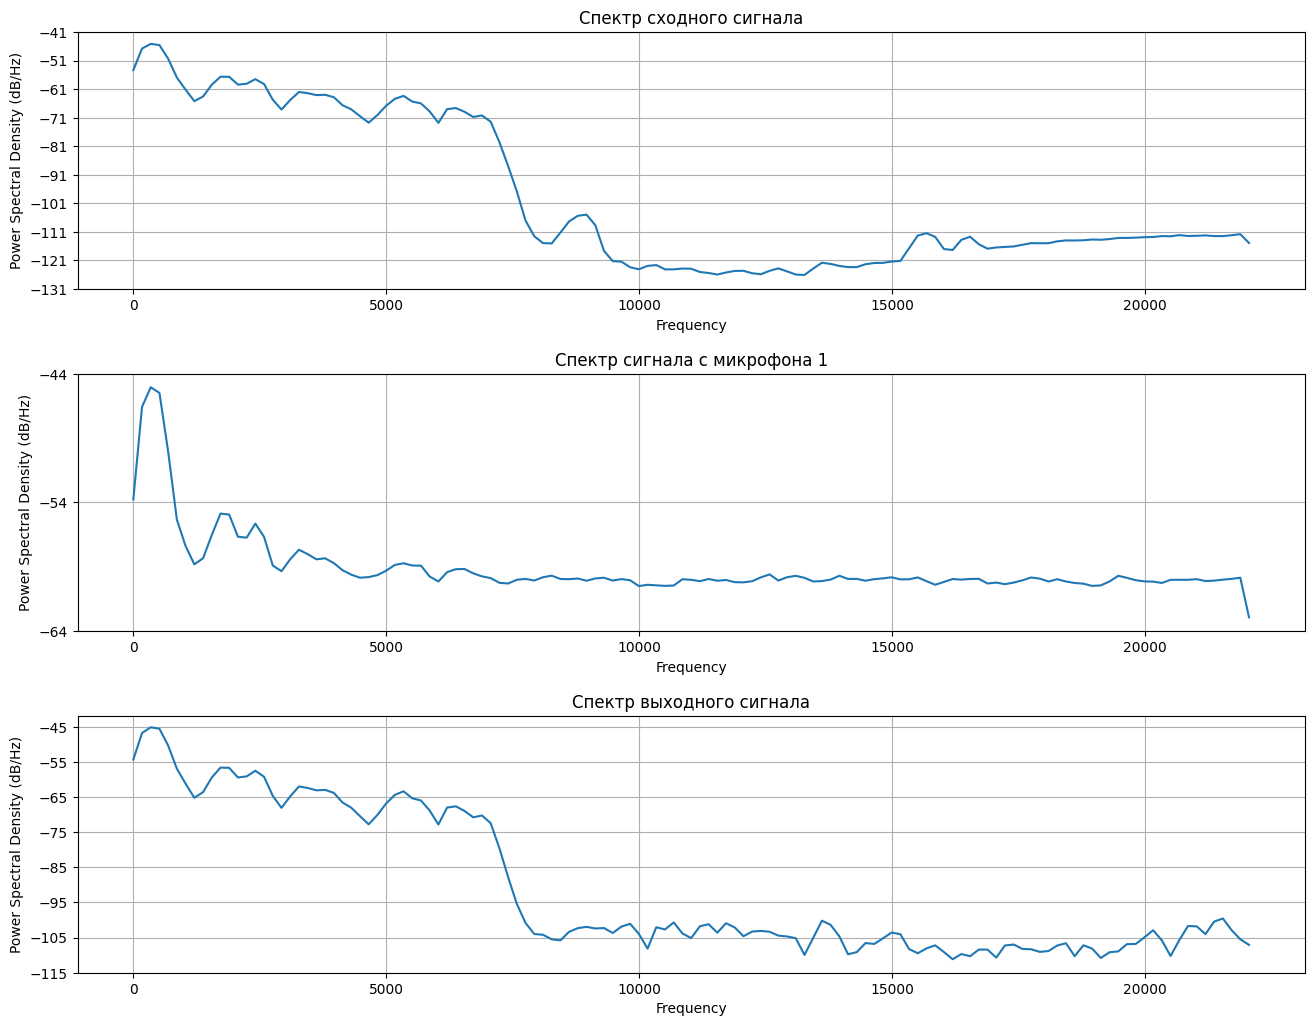

In [15]:
# Визуализация спектральной плотности мощности
fig, ax = plt.subplots(3, 1, figsize=(13,10))
fig. tight_layout (h_pad=4)
for i in ax:
    i.grid(True)
ax[0].psd(microphone_1_bu, Fs=sample_rate_1)
ax[0].set_title("Спектр сходного сигнала")
ax[1].psd(microphone_1, Fs=sample_rate_1)
ax[1].set_title("Спектр сигнала с микрофона 1")
ax[2].psd(out, Fs=sample_rate_1)
ax[2].set_title("Спектр выходного сигнала")
plt.show()

In [16]:
# Выравниваем громкость до исходного значения (по уровню microphone_1)
out = np.array(out*max_mic_1, dtype=np.int16) # Масштабируем и приводим к типу int16
# приводить к типу int16 не обязательно, т.к. за нас это делает функция write_wav()
write_wav("output.wav", sample_rate_1, out)   # Записываем в аудиофайл
ipd.Audio("output.wav")